In [70]:
import os

import pandas as pd
import numpy as np

import torch
from torch import nn
from torch.nn import functional as F

import matplotlib.pyplot as plt

from torchvision import datasets, transforms
from torch.utils.data import DataLoader

In [71]:
transform = transforms.Compose([
    transforms.RandomRotation(degrees=4),
    transforms.ToTensor(),
    transforms.Normalize((0.5, ), (0.5, ))
])

In [72]:
root = "./datasets/"

train_dataset = datasets.MNIST(root=root, train=True, transform=transform, download=True)
val_dataset = datasets.MNIST(root=root, train=False, transform=transform, download=True)

train_dataloader = DataLoader(train_dataset, batch_size=4, shuffle=True, num_workers=2)
val_dataloader = DataLoader(val_dataset, batch_size=4, shuffle=False, num_workers=2)

In [73]:
train_dataloader.dataset.train_data.shape

torch.Size([60000, 28, 28])

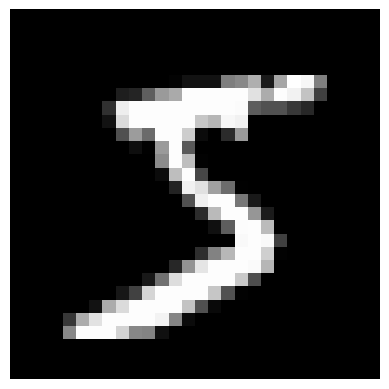

In [74]:
plt.grid(False)
plt.axis('off')
plt.imshow(train_dataloader.dataset.train_data[0], cmap="grey");

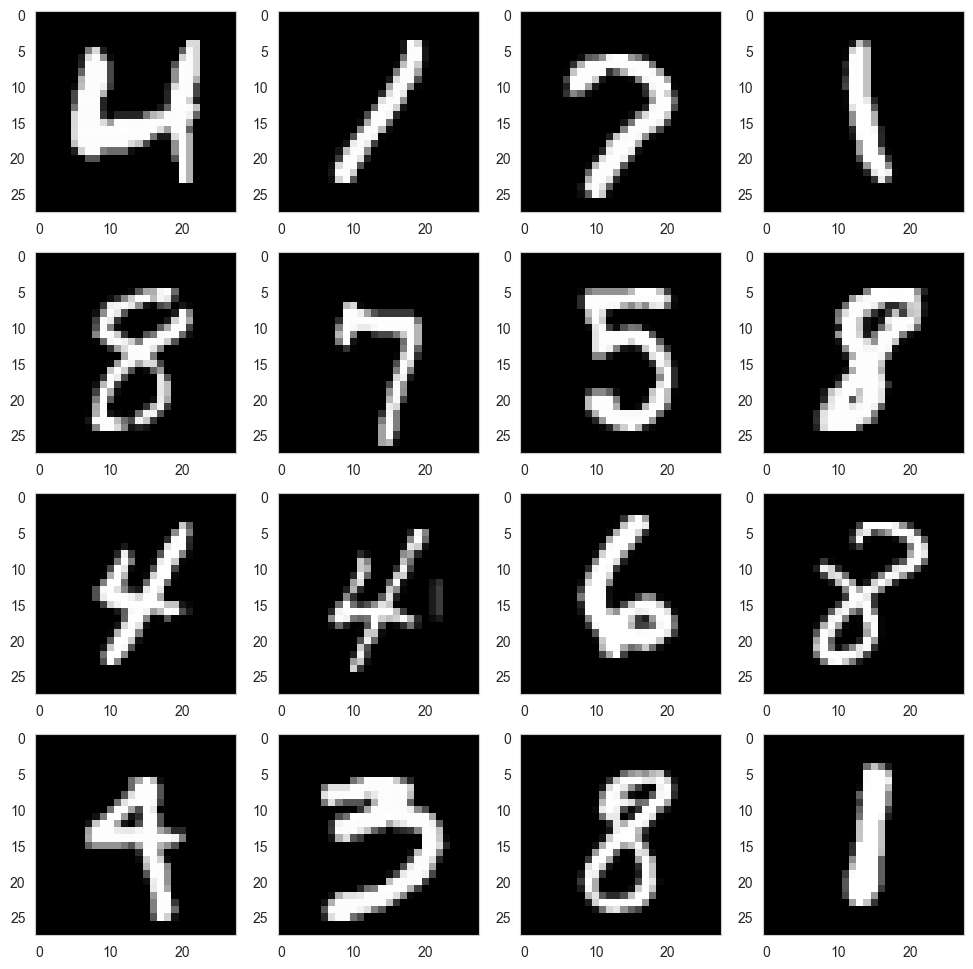

In [75]:
np.random.seed(0)

figure, ax = plt.subplots(4, 4)

figure.set_figheight(12)
figure.set_figwidth(12)

for i in range(4):
    for j in range(4):
        ax[i, j].grid(False)
        ax[i, j].imshow(train_dataloader.dataset.train_data[np.random.randint(0, 60000)], cmap="grey")

In [76]:
loaders = {"train": train_dataloader, "valid": val_dataloader}

In [77]:
def test_activation_function(activation):
    
    print()
    print(activation)
    
    model = nn.Sequential(
        nn.Flatten(),
        nn.Linear(28 * 28, 128),
        activation(),
        nn.Linear(128, 128),
        activation(),
        nn.Linear(128, 10)
    )

    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters())

    max_epochs = 10
    accuracy = {"train": [], "valid": []}
    for epoch in range(max_epochs):
        for k, dataloader in loaders.items():
            epoch_correct = 0
            epoch_all = 0
            for x_batch, y_batch in dataloader:
                if k == "train":
                    model.train()
                    optimizer.zero_grad()
                    output = model(x_batch)
                else:
                    model.eval()
                    output = model(x_batch)
                predictions = output.argmax(-1)
                correct = (predictions == y_batch).sum()
                epoch_correct += correct.item()
                epoch_all += len(predictions)
                if k == "train":
                    loss = criterion(output, y_batch)
                    loss.backward()
                    optimizer.step()
            if k == "train":
                print(f"Epoch: {epoch+1}")
            print(f"Loader: {k}. Accuracy: {epoch_correct/epoch_all}")
            accuracy[k].append(epoch_correct/epoch_all)

    return accuracy["valid"]

In [78]:
class Identical(nn.Module):
    def forward(self, x):
        return x

In [79]:
plain_accuracy = test_activation_function(Identical)
relu_accuracy = test_activation_function(nn.ReLU)
leaky_relu_accuracy = test_activation_function(nn.LeakyReLU)


<class '__main__.Identical'>
Epoch: 1
Loader: train. Accuracy: 0.8479666666666666
Loader: valid. Accuracy: 0.8785
Epoch: 2
Loader: train. Accuracy: 0.8795666666666667
Loader: valid. Accuracy: 0.8863
Epoch: 3
Loader: train. Accuracy: 0.8873
Loader: valid. Accuracy: 0.9097
Epoch: 4
Loader: train. Accuracy: 0.89115
Loader: valid. Accuracy: 0.8938
Epoch: 5
Loader: train. Accuracy: 0.8927666666666667
Loader: valid. Accuracy: 0.8786
Epoch: 6
Loader: train. Accuracy: 0.8955833333333333
Loader: valid. Accuracy: 0.8964
Epoch: 7
Loader: train. Accuracy: 0.8977166666666667
Loader: valid. Accuracy: 0.9069
Epoch: 8
Loader: train. Accuracy: 0.89855
Loader: valid. Accuracy: 0.9114
Epoch: 9
Loader: train. Accuracy: 0.9008166666666667
Loader: valid. Accuracy: 0.8839
Epoch: 10
Loader: train. Accuracy: 0.9012166666666667
Loader: valid. Accuracy: 0.901

<class 'torch.nn.modules.activation.ReLU'>
Epoch: 1
Loader: train. Accuracy: 0.8998833333333334
Loader: valid. Accuracy: 0.947
Epoch: 2
Loader: train. Ac

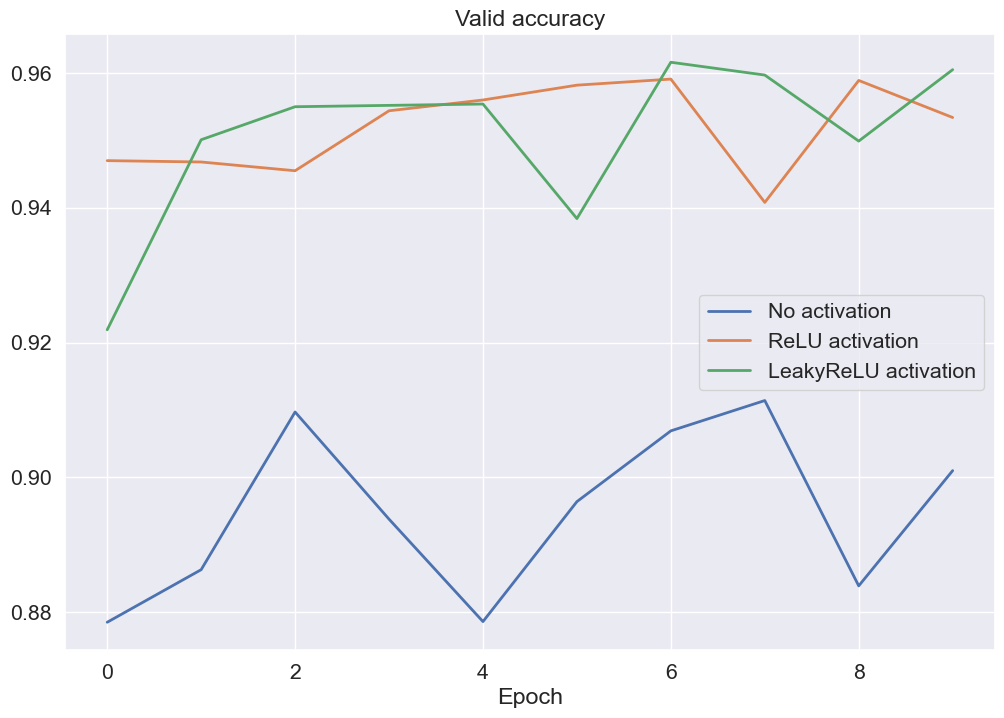

In [81]:
import seaborn as sns

max_epochs = 10

sns.set(style="darkgrid", font_scale=1.4)

plt.figure(figsize=(12, 8))
plt.title("Valid accuracy")
plt.plot(range(max_epochs), plain_accuracy, label="No activation", linewidth=2)
plt.plot(range(max_epochs), relu_accuracy, label="ReLU activation", linewidth=2)
plt.plot(range(max_epochs), leaky_relu_accuracy, label="LeakyReLU activation", linewidth=2)
plt.legend()
plt.xlabel("Epoch")
plt.show()

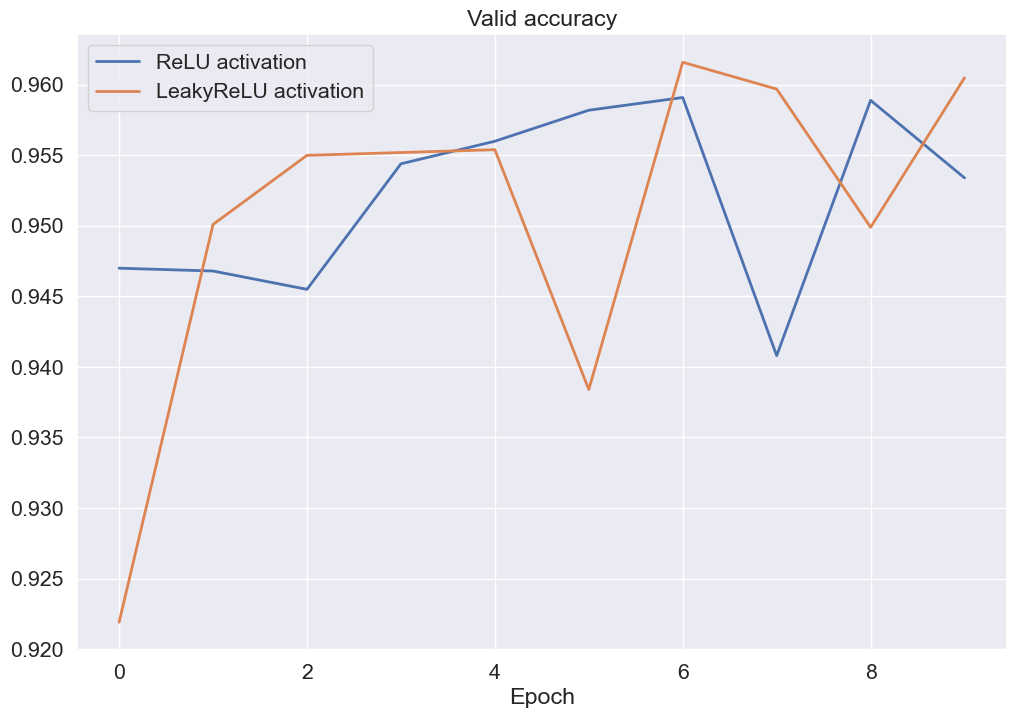

In [82]:
plt.figure(figsize=(12, 8))
plt.title("Valid accuracy")
plt.plot(range(max_epochs), relu_accuracy, label="ReLU activation", linewidth=2)
plt.plot(range(max_epochs), leaky_relu_accuracy, label="LeakyReLU activation", linewidth=2)
plt.legend()
plt.xlabel("Epoch")
plt.show()

In [91]:
transform = transforms.Compose([
    transforms.RandomCrop((26, 26)),
    transforms.RandomRotation(degrees=5),
    transforms.ToTensor(),
    transforms.Normalize((0.5, ), (0.5, ))
])

In [96]:
class LeNet(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=6, kernel_size=3)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=1)
        self.conv2 = nn.Conv2d(in_channels=6 ,out_channels=16, kernel_size=3)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=1)
        self.fc1 = nn.Linear(16 * 20 * 20, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)
    
    def forward(self, x):
        x = F.relu(self.pool1(self.conv1(x)))
        x = F.relu(self.pool2(self.conv2(x)))
        x = torch.flatten(x, start_dim=1) # x = x.view(-1, 16 * 22 * 22)
        #print(x.shape)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [97]:
root = "./datasets/"

train_dataset = datasets.MNIST(root=root, train=True, transform=transform, download=True)
val_dataset = datasets.MNIST(root=root, train=False, transform=transform, download=True)

train_dataloader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=2)
val_dataloader = DataLoader(val_dataset, batch_size=16, shuffle=False, num_workers=2)

In [98]:
model = LeNet()

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

loaders = {"train": train_dataloader, "valid": val_dataloader}

In [99]:
max_epochs = 10
accuracy = {"train": [], "valid": []}
for epoch in range(max_epochs):
    for k, dataloader in loaders.items():
        epoch_correct = 0
        epoch_all = 0
        for x_batch, y_batch in dataloader:
            if k == "train":
                model.train()
                optimizer.zero_grad()
                output = model(x_batch)
            else:
                model.eval()
                output = model(x_batch)
            predictions = output.argmax(-1)
            correct = (predictions == y_batch).sum()
            epoch_correct += correct.item()
            epoch_all += len(predictions)
            if k == "train":
                loss = criterion(output, y_batch)
                loss.backward()
                optimizer.step()
        if k == "train":
            print(f"Epoch: {epoch+1}")
        print(f"Loader: {k}. Accuracy: {epoch_correct/epoch_all}")
        accuracy[k].append(epoch_correct/epoch_all)

Epoch: 1
Loader: train. Accuracy: 0.93575
Loader: valid. Accuracy: 0.9742
Epoch: 2
Loader: train. Accuracy: 0.9746833333333333
Loader: valid. Accuracy: 0.9792
Epoch: 3
Loader: train. Accuracy: 0.9799166666666667
Loader: valid. Accuracy: 0.981
Epoch: 4
Loader: train. Accuracy: 0.9825666666666667
Loader: valid. Accuracy: 0.9765
Epoch: 5
Loader: train. Accuracy: 0.98575
Loader: valid. Accuracy: 0.9847
Epoch: 6
Loader: train. Accuracy: 0.98625
Loader: valid. Accuracy: 0.9836
Epoch: 7
Loader: train. Accuracy: 0.9877166666666667
Loader: valid. Accuracy: 0.9854
Epoch: 8
Loader: train. Accuracy: 0.9887333333333334
Loader: valid. Accuracy: 0.9861
Epoch: 9
Loader: train. Accuracy: 0.9898833333333333
Loader: valid. Accuracy: 0.988
Epoch: 10
Loader: train. Accuracy: 0.9897833333333333
Loader: valid. Accuracy: 0.9862


In [100]:
lenet_accuracy = accuracy["valid"]

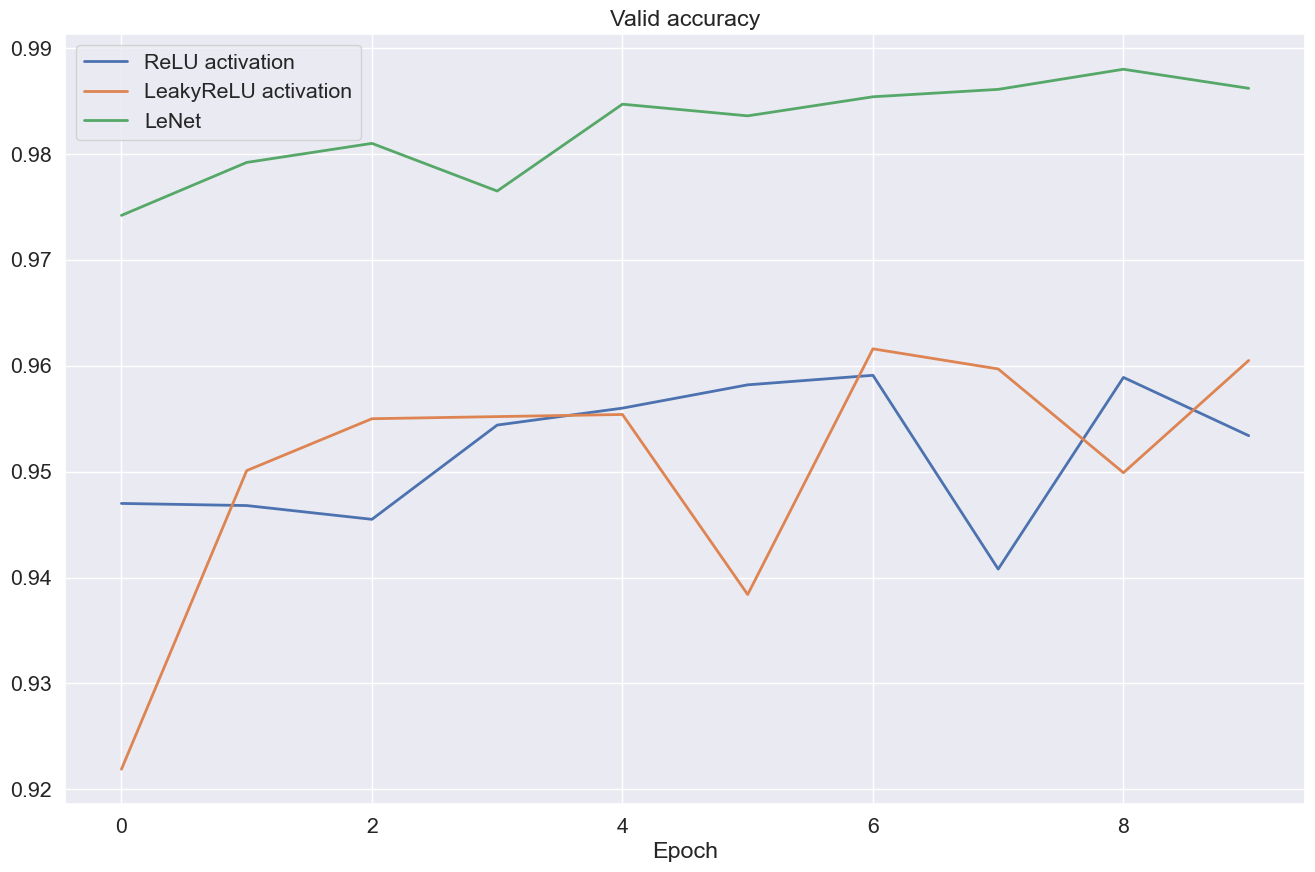

In [101]:
plt.figure(figsize=(16, 10))
plt.title("Valid accuracy")
plt.plot(range(max_epochs), relu_accuracy, label="ReLU activation", linewidth=2)
plt.plot(range(max_epochs), leaky_relu_accuracy, label="LeakyReLU activation", linewidth=2)
plt.plot(range(max_epochs), lenet_accuracy, label="LeNet", linewidth=2)
plt.legend()
plt.xlabel("Epoch")
plt.show()